# Installing requirements

In [1]:
dataset_path = 'dataset.json'
batch_dataset_path = 'batch_dataset.json'
seed = 0

In [2]:
!pip install huggingface_hub
!pip install datasets
!pip install scikit-learn
!pip install matplotlib

from pathlib import Path
from huggingface_hub import notebook_login
import datasets
import warnings
from tqdm import tqdm, TqdmWarning
warnings.filterwarnings('ignore', category = TqdmWarning)
import numpy as np
import pandas as pd
import json
from sklearn.feature_extraction.text import CountVectorizer
import random
import matplotlib.pyplot as plt
import matplotlib.colors as colors

You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\Homeworkace\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


# Download the dataset

In [3]:
if Path(dataset_path).exists() :
    dataset = pd.read_json(dataset_path)
else :
    notebook_login()
    hugging_face_dataset = datasets.load_dataset('lmsys/chatbot_arena_conversations')
    dataset = hugging_face_dataset['train'].to_pandas()
    dataset.to_json(dataset_path)

In [4]:
dataset[dataset['turn'] > 3][:1]

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn,anony,language,tstamp,openai_moderation,toxic_chat_tag
33,8120899314f74641b09c2aa114d4d253,alpaca-13b,vicuna-13b,model_b,arena_user_316,[{'content': 'Salut ! Comment ça va ce matin ?...,[{'content': 'Salut ! Comment ça va ce matin ?...,6,True,French,1.682354e+09,"{'categories': {'harassment': False, 'harassme...","{'roberta-large': {'flagged': False, 'probabil..."


# Create text-author pairs

In [5]:
# Initialize an empty list for processed data
text_author_pairs = []

# Iterate through each row of the DataFrame
for _, row in dataset.iterrows():
    # Process conversation_a (assistant role)
    for message in row["conversation_a"]:
        if message["role"] == "assistant":
            text_author_pairs.append({
                "text": message["content"],
                "author": row["model_a"]
            })

    # Process conversation_b (assistant role)
    for message in row["conversation_b"]:
        if message["role"] == "assistant":
            text_author_pairs.append({
                "text": message["content"],
                "author": row["model_b"]
            })

    # Process user messages (common across both conversations)
    for message in row["conversation_a"]:  # Check only `conversation_a` since user messages are identical
        if message["role"] == "user":
            text_author_pairs.append({
                "text": message["content"],
                "author": "human"
            })

# Create token count vectors for each text

In [6]:
# Extract texts and their authors
texts = [entry['text'] for entry in text_author_pairs]
authors = [entry['author'] for entry in text_author_pairs]

# Vectorize the paragraphs
vectoriser = CountVectorizer()
text_vectors = vectoriser.fit_transform(texts)  # Each row is a text

# Allocate quotas for each batch.
batch_count = {} 
for author in list(set(authors)) :
    # Find out how many batches of 200 texts are needed.
    number_of_batches = round(authors.count(author) / 200)
    for i in range(number_of_batches) :
        # Distribute the remainder/shortfall evenly.
        batch_count[str(i) + '_' + author] = np.floor((i + 1) * authors.count(author) / number_of_batches)
        for j in range(i) :
            # Subtract the count of previous batches.
            batch_count[str(i) + '_' + author] -= batch_count[str(j) + '_' + author]
        
print('Populating batches...')
batch_vectors = {}
batch_quota = batch_count.copy()
for i, author in enumerate(tqdm(authors)):
    batch_to_insert = [name for name in batch_quota if author in name and batch_quota[name] > 0][0]
    if batch_to_insert in batch_vectors:
        # The resulting vectors represent the number of times each token appears in that author's entire corpus.
        batch_vectors[batch_to_insert] += text_vectors[i].toarray()
    else:
        # Add this new batch to the list.
        batch_vectors[batch_to_insert] = text_vectors[i].toarray()
    batch_quota[batch_to_insert] -= 1

# Convert to a dataframe
print('Converting into DataFrame...')
batch_dataset = pd.DataFrame({name: vector.flatten() for name, vector in tqdm(batch_vectors.items())}, index = vectoriser.get_feature_names_out())

batch_dataset

Populating batches...


100%|████████████████████████████████████████████████████████████████████████| 117948/117948 [01:21<00:00, 1439.96it/s]


Converting into DataFrame...


100%|██████████████████████████████████████████████████████████████████████████████| 591/591 [00:00<00:00, 2023.52it/s]


,0_chatglm-6b,0_koala-13b,0_human,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_human,...,190_human,191_human,192_human,6_wizardlm-13b,193_human,6_gpt4all-13b-snoozy,5_guanaco-33b,194_human,195_human,196_human
00,0,0,0,0,8,3,1,0,1,3,...,0,0,0,3,0,0,0,0,0,2
000,3,1,0,4,0,2,4,0,0,0,...,0,0,3,6,0,3,0,7,2,0
0000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
000000,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｔｏ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ｗｅｅｋｓ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝘀𝗶𝗺𝗽𝗹𝗲,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Group texts by author

In [7]:
# Find the average text length of each author. 
batch_average_length = {name: np.sum(vector) / batch_count[name] for name, vector in batch_vectors.items()}

# Normalise the length of each corpus.
print('Normalising...')
for name in tqdm(batch_vectors) :
    batch_dataset[name] /= np.sum(batch_vectors[name])
    
# Since it has been lost, add the average text length as a separate feature.
batch_dataset = pd.concat([batch_dataset, pd.DataFrame(batch_average_length, index = [' length'])])

batch_dataset

Normalising...


100%|████████████████████████████████████████████████████████████████████████████████| 591/591 [01:11<00:00,  8.31it/s]


,0_chatglm-6b,0_koala-13b,0_human,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_human,...,190_human,191_human,192_human,6_wizardlm-13b,193_human,6_gpt4all-13b-snoozy,5_guanaco-33b,194_human,195_human,196_human
00,0.000000,0.000000,0.000000,0.000000,0.000926,0.000135,0.000083,0.000000,0.000095,0.000755,...,0.00,0.000,0.000000,0.000124,0.000,0.000000,0.000000,0.000000,0.000000,0.000241
000,0.000095,0.000041,0.000000,0.000201,0.000000,0.000090,0.000331,0.000000,0.000000,0.000000,...,0.00,0.000,0.000619,0.000248,0.000,0.000157,0.000000,0.000939,0.000454,0.000000
0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
000000,0.000000,0.000082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｗｅｅｋｓ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻𝘀,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000


In [8]:
batch_dataset.to_json(batch_dataset_path)

# Custom holdout

In [25]:
def holdout(df, authors) :
    holdout_list = []
    for author in authors :
        batch = df[random.choice([batch for batch in df.columns if author in batch])].copy()
        holdout_list.append(batch)

    holdout_df = pd.concat(holdout_list, axis = 1)
    training_df = df.drop(columns = holdout_df.columns).copy()
    return training_df, holdout_df

In [26]:
random.seed(seed)
training_dataset, holdout_dataset = holdout(batch_dataset, list(set(authors)))

training_dataset

,0_chatglm-6b,0_koala-13b,0_human,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_human,...,190_human,191_human,192_human,6_wizardlm-13b,193_human,6_gpt4all-13b-snoozy,5_guanaco-33b,194_human,195_human,196_human
00,0.000000,0.000000,0.000000,0.000000,0.000926,0.000135,0.000083,0.000000,0.000095,0.000755,...,0.00,0.000,0.000000,0.000124,0.000,0.000000,0.000000,0.000000,0.000000,0.000241
000,0.000095,0.000041,0.000000,0.000201,0.000000,0.000090,0.000331,0.000000,0.000000,0.000000,...,0.00,0.000,0.000619,0.000248,0.000,0.000157,0.000000,0.000939,0.000454,0.000000
0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
000000,0.000000,0.000082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ｗｅｅｋｓ,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝗶𝗺𝗽𝗹𝗲,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000
𝘀𝘂𝗽𝗲𝗿𝗵𝘂𝗺𝗮𝗻𝘀,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000


# Feature selection

In [27]:
human_dataset = training_dataset[[name for name in training_dataset.columns if 'human' in name]].copy()
llm_dataset = training_dataset[[name for name in training_dataset.columns if not 'human' in name]].copy()
training_dataset = pd.merge(llm_dataset[llm_dataset.ne(0).sum(axis=1) == llm_dataset.shape[1]], human_dataset, left_index=True, right_index=True, validate='1:1')
holdout_dataset = holdout_dataset.loc[training_dataset.index].copy()

training_dataset

,0_chatglm-6b,0_koala-13b,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_vicuna-13b,1_koala-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
10,0.000698,0.000945,0.000705,0.000463,0.000630,0.000994,0.000687,0.001040,0.000472,0.000806,...,0.001238,0.000262,0.001459,0.001037,0.001772,0.001856,0.002592,0.001610,0.000227,0.000481
about,0.001776,0.001068,0.001309,0.000810,0.002116,0.001160,0.003070,0.002459,0.001769,0.002110,...,0.001856,0.003148,0.005209,0.005965,0.002658,0.005568,0.003672,0.004428,0.002496,0.001443
after,0.000317,0.000205,0.000554,0.000231,0.000180,0.000580,0.000404,0.000095,0.000708,0.000345,...,0.000619,0.000262,0.000417,0.000259,0.001624,0.000825,0.000864,0.005233,0.000227,0.000601
all,0.001237,0.001068,0.001107,0.001620,0.000856,0.000994,0.002101,0.001797,0.000708,0.001189,...,0.003249,0.001574,0.001459,0.002075,0.002805,0.002475,0.002592,0.002147,0.001815,0.000241
also,0.003075,0.002998,0.002718,0.004165,0.003062,0.002486,0.002747,0.002838,0.002713,0.003108,...,0.000309,0.001049,0.000417,0.000259,0.000886,0.000412,0.001080,0.001342,0.000908,0.000241
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
world,0.000919,0.001027,0.000856,0.001620,0.001396,0.000994,0.001656,0.002459,0.001455,0.001650,...,0.000464,0.000787,0.000417,0.000259,0.000000,0.000825,0.001944,0.000000,0.000681,0.000361
would,0.000476,0.001930,0.001057,0.003008,0.001891,0.001740,0.002141,0.001419,0.001455,0.001919,...,0.001238,0.001049,0.003751,0.003112,0.002362,0.003300,0.001080,0.001476,0.002042,0.000722
you,0.009480,0.010103,0.012080,0.010066,0.008240,0.010108,0.013492,0.013432,0.008965,0.009247,...,0.008199,0.017576,0.012294,0.013485,0.005758,0.016498,0.013610,0.013149,0.010211,0.003007
your,0.003234,0.004271,0.006845,0.003587,0.004233,0.002900,0.004039,0.003689,0.003146,0.005986,...,0.001547,0.002099,0.003126,0.002334,0.002658,0.003300,0.006697,0.002549,0.003177,0.000962


# Centring

In [28]:
features_mean = pd.Series({feature: np.mean(training_dataset.loc[feature]) for feature in training_dataset.index})
for batch in training_dataset.columns :
    training_dataset[batch] -= features_mean
for batch in holdout_dataset.columns :
    holdout_dataset[batch] -= features_mean
    
training_dataset

,0_chatglm-6b,0_koala-13b,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_vicuna-13b,1_koala-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
10,-0.000752,-5.054175e-04,-0.000745,-0.000987,-0.000820,-0.000456,-0.000763,-0.000410,-0.000978,-0.000644,...,-0.000212,-0.001188,0.000009,-0.000413,0.000322,0.000406,0.001142,0.000160,-0.001223,-0.000969
about,-0.000569,-1.276468e-03,-0.001036,-0.001534,-0.000228,-0.001184,0.000726,0.000115,-0.000575,-0.000234,...,-0.000488,0.000804,0.002865,0.003620,0.000313,0.003224,0.001328,0.002083,0.000152,-0.000901
after,-0.000261,-3.728860e-04,-0.000025,-0.000347,-0.000398,0.000002,-0.000174,-0.000484,0.000130,-0.000233,...,0.000041,-0.000316,-0.000161,-0.000319,0.001046,0.000247,0.000286,0.004655,-0.000351,0.000023
all,-0.000368,-5.366484e-04,-0.000497,0.000015,-0.000749,-0.000610,0.000496,0.000193,-0.000897,-0.000415,...,0.001644,-0.000030,-0.000146,0.000470,0.001201,0.000870,0.000988,0.000542,0.000211,-0.001364
also,0.001368,1.291081e-03,0.001011,0.002458,0.001355,0.000779,0.001040,0.001131,0.001006,0.001401,...,-0.001398,-0.000658,-0.001290,-0.001448,-0.000821,-0.001295,-0.000627,-0.000365,-0.000799,-0.001466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
world,-0.000121,-1.388087e-05,-0.000185,0.000579,0.000355,-0.000046,0.000616,0.001419,0.000414,0.000609,...,-0.000577,-0.000254,-0.000624,-0.000781,-0.001041,-0.000216,0.000904,-0.001041,-0.000360,-0.000680
would,-0.001300,1.543301e-04,-0.000719,0.001232,0.000115,-0.000036,0.000365,-0.000357,-0.000321,0.000143,...,-0.000538,-0.000727,0.001975,0.001336,0.000586,0.001524,-0.000696,-0.000300,0.000266,-0.001054
you,-0.001259,-6.355960e-04,0.001341,-0.000673,-0.002499,-0.000631,0.002753,0.002693,-0.001773,-0.001492,...,-0.002539,0.006837,0.001556,0.002747,-0.004981,0.005760,0.002871,0.002410,-0.000528,-0.007732
your,-0.001036,7.908916e-07,0.002575,-0.000684,-0.000038,-0.001371,-0.000231,-0.000581,-0.001125,0.001715,...,-0.002723,-0.002172,-0.001145,-0.001936,-0.001613,-0.000971,0.002426,-0.001721,-0.001094,-0.003308


# Standardisation

In [29]:
features_std = pd.Series({feature: np.std(training_dataset.loc[feature]) for feature in training_dataset.index})
for batch in training_dataset.columns :
    training_dataset[batch] /= features_std
for batch in holdout_dataset.columns :
    holdout_dataset[batch] /= features_std

training_dataset

,0_chatglm-6b,0_koala-13b,0_oasst-pythia-12b,0_alpaca-13b,0_vicuna-13b,0_dolly-v2-12b,0_stablelm-tuned-alpha-7b,0_llama-13b,1_vicuna-13b,1_koala-13b,...,187_human,188_human,189_human,190_human,191_human,192_human,193_human,194_human,195_human,196_human
10,-0.475991,-0.319705,-0.471484,-0.624467,-0.518468,-0.288328,-0.482838,-0.259051,-0.618734,-0.407520,...,-0.134349,-0.751277,0.005454,-0.261037,0.203510,0.256842,0.722592,0.101256,-0.773681,-0.612882
about,-0.402669,-0.903726,-0.733220,-1.086318,-0.161432,-0.838524,0.513781,0.081456,-0.406938,-0.165614,...,-0.345384,0.568997,2.028493,2.563246,0.221840,2.282477,0.940370,1.475078,0.107441,-0.637846
after,-0.517636,-0.739040,-0.048714,-0.687402,-0.789064,0.003403,-0.345435,-0.958555,0.256789,-0.461601,...,0.080425,-0.626104,-0.320044,-0.632037,2.072842,0.488905,0.566607,9.225081,-0.696300,0.045906
all,-0.400148,-0.583642,-0.540681,0.016698,-0.814530,-0.663693,0.539485,0.209625,-0.975176,-0.451323,...,1.788299,-0.033146,-0.158586,0.511413,1.305956,0.946493,1.074408,0.589824,0.229303,-1.483332
also,1.438901,1.357528,1.062979,2.584747,1.424561,0.818579,1.093335,1.188888,1.058022,1.473088,...,-1.469511,-0.691518,-1.356638,-1.522157,-0.863378,-1.361157,-0.659103,-0.384045,-0.840481,-1.541902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
world,-0.188981,-0.021653,-0.288534,0.903478,0.554097,-0.072405,0.960190,2.213042,0.646266,0.950437,...,-0.899294,-0.395635,-0.973163,-1.218718,-1.623256,-0.336477,1.409597,-1.623256,-0.561379,-1.060387
would,-1.377842,0.163527,-0.761804,1.305719,0.122056,-0.038233,0.386711,-0.378373,-0.340148,0.151064,...,-0.570391,-0.769919,2.092539,1.415724,0.621333,1.614521,-0.737253,-0.317898,0.282140,-1.117088
you,-0.315734,-0.159439,0.336402,-0.168755,-0.626819,-0.158280,0.690590,0.675546,-0.444819,-0.374143,...,-0.637015,1.715161,0.390209,0.689034,-1.249365,1.444788,0.720234,0.604646,-0.132362,-1.939499
your,-0.507752,0.000387,1.261364,-0.334951,-0.018574,-0.671494,-0.113170,-0.284848,-0.550972,0.840320,...,-1.334190,-1.063959,-0.560826,-0.948643,-0.790118,-0.475585,1.188728,-0.843175,-0.535786,-1.620682


C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_9408\1364267143.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  feature_graph_figure.show()


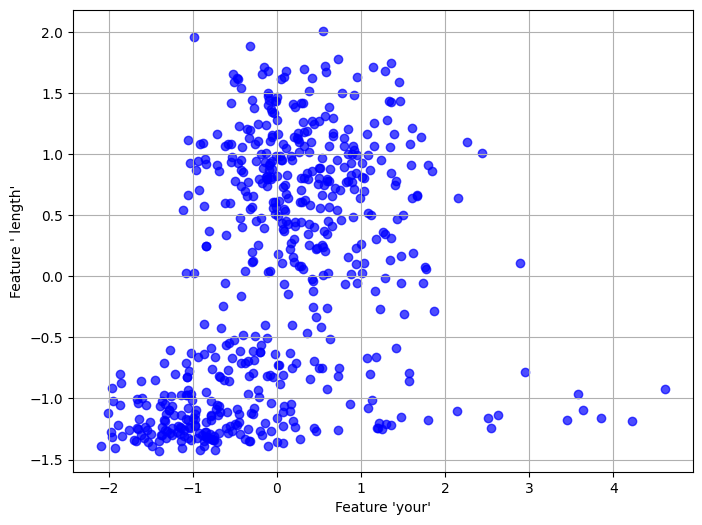

In [30]:
# Extracting the two features
x_token = training_dataset.index[-2]
y_token = training_dataset.index[-1]

# Creating the scatter plot
feature_graph_figure = plt.figure(figsize=(8, 6))
feature_graph = feature_graph_figure.subplots()
feature_graph.scatter(training_dataset.loc[x_token], training_dataset.loc[y_token], color='blue', alpha=0.7)
feature_graph.set_xlabel("Feature '" + x_token + "'")
feature_graph.set_ylabel("Feature '" + y_token + "'")
feature_graph.grid(True)
feature_graph_figure.show()

In [31]:
def power_iteration(A, num_iter=1000, tol=1e-6):
    """
    Power Iteration to compute the largest eigenvector of matrix A.
    Args:
        A (np.ndarray): Input symmetric matrix.
        num_iter (int): Number of iterations.
        tol (float): Tolerance for convergence.

    Returns:
        eigenvector (np.ndarray): Approximation of the largest eigenvector.
        eigenvalue (float): Corresponding eigenvalue.
    """
    b = np.random.rand(A.shape[1])  # Random initial vector
    b = b / np.linalg.norm(b)

    error_meter = tqdm(position = 0, total=6, bar_format='{bar} | {postfix}')
    for i in range(num_iter):
        b_next = A @ b  # Matrix-vector multiplication
        b_next = b_next / np.linalg.norm(b_next)  # Normalize
        
        # Check for convergence
        error = np.linalg.norm(b_next - b)
        b = b_next
        error_meter.update(min(-np.log10(error), error_meter.total) - error_meter.n)
        error_meter.set_postfix_str('{:.2E}'.format(error) + ' of error after ' + str(i + 1) + ' iterations...')
        if error < tol:
            error_meter.close()
            break

    eigenvalue = b.T @ A @ b  # Rayleigh quotient for eigenvalue
    return b, eigenvalue

In [32]:
def pca_power_iteration(data, num_components, num_iter=2000):
    """
    PCA using Power Iteration to compute the principal components.
    Args:
        data (np.ndarray): Input data matrix (rows are samples, columns are features).
        num_components (int): Number of principal components to compute.
        num_iter (int): Number of iterations for power iteration.

    Returns:
        components (list): List of principal components (eigenvectors).
        explained_variance (list): List of corresponding eigenvalues.
    """
    # Step 1: Center the data
    covariance_matrix = np.cov(data, rowvar=True, ddof = 0)
    
    # Compute covariance matrix manually
    n = data.shape[1]  # Number of samples (columns in your case)
    covariance_matrix = (data @ data.T) / n

    components = []
    explained_variance = []

    for i in range(num_components):
        # Step 2: Compute the largest eigenvector using power iteration
        print('Extracting PC' + str(i + 1) + '...')
        eigenvector, eigenvalue = power_iteration(covariance_matrix, num_iter=num_iter)
        components.append(eigenvector)
        explained_variance.append(eigenvalue)
        
        # Step 3: Deflate the covariance matrix
        covariance_matrix -= eigenvalue * np.outer(eigenvector, eigenvector)
        if np.linalg.norm(covariance_matrix, ord='fro') < 1e-10 :
            print('Stopped as all variance has been extracted after computing ' + str(i + 1) + ' PCs.')
            break
        
    return components, explained_variance

In [160]:
components, explained_variance = pca_power_iteration(training_dataset, num_components=50)

Extracting PC1...


██████████████████████████████████████████████████████████████████████████ | , 4.26E-07 of error after 14 iterations...


Extracting PC2...


██████████████████████████████████████████████████████████████████████████ | , 8.94E-07 of error after 38 iterations...


Extracting PC3...


██████████████████████████████████████████████████████████████████████████ | , 7.64E-07 of error after 30 iterations...


Extracting PC4...


█████████████████████████████████████████████████████████████████████████ | , 9.58E-07 of error after 155 iterations...


Extracting PC5...


█████████████████████████████████████████████████████████████████████████ | , 9.73E-07 of error after 159 iterations...


Extracting PC6...


█████████████████████████████████████████████████████████████████████████ | , 9.44E-07 of error after 145 iterations...


Extracting PC7...


█████████████████████████████████████████████████████████████████████████ | , 9.82E-07 of error after 169 iterations...


Extracting PC8...


█████████████████████████████████████████████████████████████████████████ | , 9.92E-07 of error after 211 iterations...


Extracting PC9...


█████████████████████████████████████████████████████████████████████████ | , 9.95E-07 of error after 370 iterations...


Extracting PC10...


█████████████████████████████████████████████████████████████████████████ | , 9.91E-07 of error after 186 iterations...


Extracting PC11...


█████████████████████████████████████████████████████████████████████████ | , 9.69E-07 of error after 153 iterations...


Extracting PC12...


█████████████████████████████████████████████████████████████████████████ | , 9.92E-07 of error after 213 iterations...


Extracting PC13...


█████████████████████████████████████████████████████████████████████████ | , 9.87E-07 of error after 485 iterations...


Extracting PC14...


█████████████████████████████████████████████████████████████████████████ | , 9.70E-07 of error after 229 iterations...


Extracting PC15...


██████████████████████████████████████████████████████▌                   | , 3.25E-05 of error after 371 iterations...IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

█████████████████████████████████████████████████████████████████████████ | , 9.94E-07 of error after 812 iterations...


Extracting PC17...


█████████████████████████████████████████████████████████████████████████ | , 9.68E-07 of error after 236 iterations...


Extracting PC18...


█████████████████████████████████████████████████████████████████████████ | , 9.78E-07 of error after 299 iterations...


Extracting PC19...


█████████████████████████████████████████████████████████████████████████ | , 9.95E-07 of error after 294 iterations...


Extracting PC20...


█████████████████████████████████████████████████████████████████████████ | , 9.90E-07 of error after 421 iterations...


Extracting PC21...


█████████████████████████████████████████████████████████████████████████ | , 9.89E-07 of error after 578 iterations...


Extracting PC22...


█████████████████████████████████████████████████████████████████████████ | , 9.70E-07 of error after 222 iterations...


Extracting PC23...


█████████████████████████████████████████████████████████████████████████ | , 9.90E-07 of error after 470 iterations...


Extracting PC24...


█████████████████████████████████████████████████████████▋                | , 1.83E-05 of error after 341 iterations...IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

█████████████████████████████████████████████████████████████████████████ | , 9.99E-07 of error after 449 iterations...


Extracting PC27...


████████████████████████████████████████████████████████████████████████ | , 1.00E-06 of error after 1668 iterations...


Extracting PC28...


█████████████████████████████████████████████████████████████████████████ | , 9.86E-07 of error after 292 iterations...


Extracting PC29...


█████████████████████████████████████████████████████████████████████████ | , 9.78E-07 of error after 324 iterations...


Extracting PC30...


█████████████████████████████████████████████████████████████████████████ | , 9.96E-07 of error after 394 iterations...


Extracting PC31...


███████████████████████▋                                                   | , 1.21E-02 of error after 93 iterations...IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

█████████████████████████████████████████████████████████████████████████ | , 9.89E-07 of error after 462 iterations...


Extracting PC34...


█████████████████████████████████████████████████████████████████████████ | , 9.75E-07 of error after 369 iterations...


Extracting PC35...


█████████████████████████████████████████████████████████████████████████ | , 9.92E-07 of error after 624 iterations...


Extracting PC36...


█████████████████████████████████████████████████████████████████████████ | , 9.93E-07 of error after 629 iterations...


Extracting PC37...


█████████████████████████████████████████████████████████████████████████ | , 9.79E-07 of error after 397 iterations...


Extracting PC38...


█████████████████████████████████████████████████████████████████████████ | , 9.79E-07 of error after 323 iterations...


Extracting PC39...


██████████████████████████████████████▍                                   | , 6.91E-04 of error after 180 iterations...IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

████████████████████████████████████████████████████████████████████████ | , 9.94E-07 of error after 1095 iterations...


Extracting PC41...


█████████████████████████████████████████████████████████████████████████ | , 9.99E-07 of error after 843 iterations...


Extracting PC42...


█████████████████████████████████████████████████████████████████████████ | , 9.89E-07 of error after 364 iterations...


Extracting PC43...


█████████████████████████████████████████████████████████████████████████ | , 9.95E-07 of error after 726 iterations...


Extracting PC44...


█████████████████████████████████████████████████████████████████████████ | , 9.93E-07 of error after 550 iterations...


Extracting PC45...


██████████████████████████▍                                                | , 7.18E-03 of error after 91 iterations...IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

█████████████████████████████████████████████████████████████████████████ | , 9.88E-07 of error after 572 iterations...


Extracting PC48...


█████████████████████████████████████████████████████████████████████████ | , 9.90E-07 of error after 474 iterations...


Extracting PC49...


█████████████████████████████████████████████████████████████████████████ | , 9.82E-07 of error after 598 iterations...


Extracting PC50...


████████████████████████████████████████████████████████████████████████ | , 1.00E-06 of error after 1103 iterations...


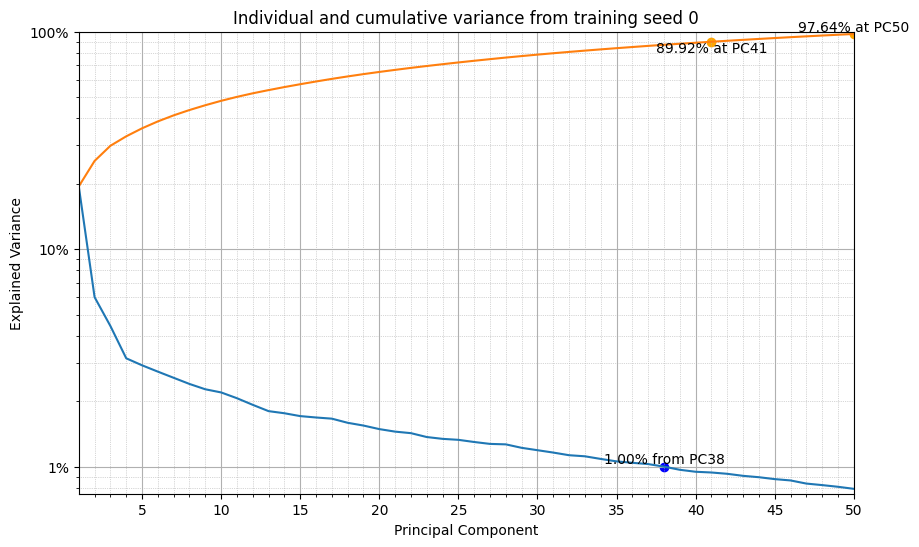

In [240]:
plt.figure(figsize=(10, 6))
plt.xticks(range(0, 51, 5))
plt.xlim(1, 50)
plt.yscale('log')
plt.ylim(0.75, 100)
plt.yticks([1, 10, 100], labels=["1%", "10%", "100%"])
plt.plot(range(1, 51), explained_variance)
plt.plot(range(1, 51), [np.sum(explained_variance[:i]) for i in range(1, 51)])

# Points of interest
plt.scatter(41, np.sum(explained_variance[:41]), color='orange')
plt.annotate('{0:.2f}'.format(np.sum(explained_variance[:41])) + '% at PC41' , (41, np.sum(explained_variance[:41])), ha = 'center', va = 'top')
plt.scatter(50, np.sum(explained_variance), color='orange')
plt.annotate('{0:.2f}'.format(np.sum(explained_variance)) + '% at PC50' , (50, np.sum(explained_variance)), ha = 'center', va = 'bottom')
plt.scatter(38, explained_variance[37], color='blue')
plt.annotate('{0:.2f}'.format(explained_variance[37]) + '% from PC38' , (38, explained_variance[37]), ha = 'center', va = 'bottom')

plt.title('Individual and cumulative variance from training seed 0')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.grid(True)
plt.minorticks_on()
#plt.grid(axis = 'x', which = 'minor')
plt.grid(which='minor', axis='x', linestyle=':', linewidth=0.5)  # Minor grid lines on X-axis
plt.grid(which='minor', axis='y', linestyle=':', linewidth=0.5)  # Minor grid lines on X-axis
plt.show()

In [47]:
def transform_to_pc(batch, components) :
    pc_space_batch = []
    for component in components :
        pc_space_batch.append(np.dot(batch, component))
        
    return pc_space_batch

C:\Users\Homeworkace\AppData\Local\Temp\ipykernel_9408\3528753702.py:16: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  feature_graph_figure.show()


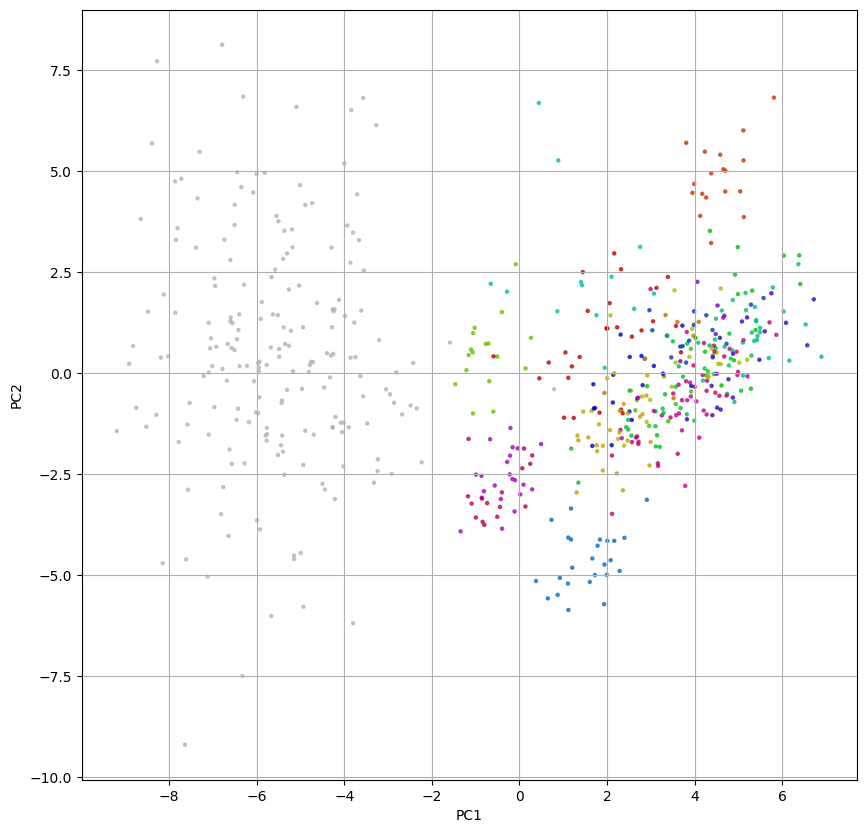

In [94]:
# Define a colour for each author.
colour_list = {author: colors.hsv_to_rgb((i / len(set(authors)), 1, 0.75)) for i, author in enumerate(list(set(authors)))}
colour_list['human'] = colors.hsv_to_rgb((0, 0, 0.7))

# Creating the scatter plot
feature_graph_figure = plt.figure(figsize=(10, 10))
feature_graph = feature_graph_figure.subplots()
coords = [transform_to_pc(training_dataset[batch], components) for batch in training_dataset]
coords += [transform_to_pc(holdout_dataset[batch], components) for batch in holdout_dataset]
feature_graph.scatter([coord[0] for coord in coords], [coord[1] for coord in coords], color=[colour_list[batch.split('_')[1]] for batch in training_dataset] + [colour_list[batch.split('_')[1]] for batch in holdout_dataset], s = 5, alpha=0.7)
#for author in list(set(authors)):
#    feature_graph.annotate(author, coords[training_dataset.columns.get_loc('0_' + author)])
feature_graph.set_xlabel("PC1")
feature_graph.set_ylabel("PC2")
feature_graph.grid(True)
feature_graph_figure.show()

In [49]:
ranking = np.argsort(components[0])
dimensions = training_dataset.index[ranking]
weights = components[0][ranking]
for i in range(len(dimensions)) :
    print(dimensions[i] + ' ' + str(weights[i]))

what -0.1905247721808767
me -0.1834313652701672
how -0.17861783412610507
do -0.1581392429538864
about -0.13560125275450358
my -0.11889669529412544
only -0.10718397431437518
should -0.10523817885181569
an -0.08910052120287226
who -0.07708995686965006
one -0.07196520366619932
at -0.07027377155452309
name -0.06605334465217398
no -0.06491440553167645
all -0.06297624057782959
like -0.06110388520988592
know -0.059860890799020135
after -0.05963557292460961
when -0.059151600717422786
10 -0.05408765862574093
first -0.05389933616505384
many -0.05336605984055466
best -0.05124092091614592
you -0.051136077040511714
would -0.04974577981640618
two -0.04936548865874345
out -0.048216575405031305
in -0.0468929203243985
where -0.04596482400624676
don -0.044361889955128894
from -0.04372448294500676
just -0.04228934088809564
get -0.03898698272088168
same -0.03771550664857866
then -0.03731506807540458
without -0.036759399401447145
each -0.036341151379705706
if -0.033901720604801774
most -0.03164852612256911

# k-Nearest Neighbours

In [131]:
def k_nearest_neighbours(X_train, y_train, X_test, k = 3):
    """
    Predict labels for the test dataset.
    """
    predictions = []

    for test_point in X_test:
        # Compute distances to all training points
        distances = [np.linalg.norm(train_point - test_point) for train_point in X_train]

        k_indices = np.argsort(distances)[:k] # Find indices of k nearest neighbors
        k_labels = y_train[k_indices] # Retrieve the labels of the k nearest neighbors
        unique_labels, counts = np.unique(k_labels, return_counts=True) # Determine the most common label (majority voting)
        while np.count_nonzero(counts == np.max(counts)) != 1 : # In the event of tiebreaks, reduce k. At k = 1 a winner is guaranteed.
            k -= 1
            unique_labels, counts = np.unique(y_train[np.argsort(distances)[:k]], return_counts=True)
        
        predictions.append(unique_labels[np.argmax(counts)])
    
    return np.array(predictions)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


['alpaca-13b' 'palm-2' 'stablelm-tuned-alpha-7b' 'gpt-3.5-turbo'
 'fastchat-t5-3b' 'dolly-v2-12b' 'vicuna-7b' 'chatglm-6b'
 'RWKV-4-Raven-14B' 'koala-13b' 'dolly-v2-12b' 'human' 'gpt-4'
 'stablelm-tuned-alpha-7b' 'mpt-7b-chat' 'RWKV-4-Raven-14B' 'koala-13b'
 'claude-instant-v1' 'koala-13b' 'vicuna-7b' 'claude-instant-v1']
11 out of 21


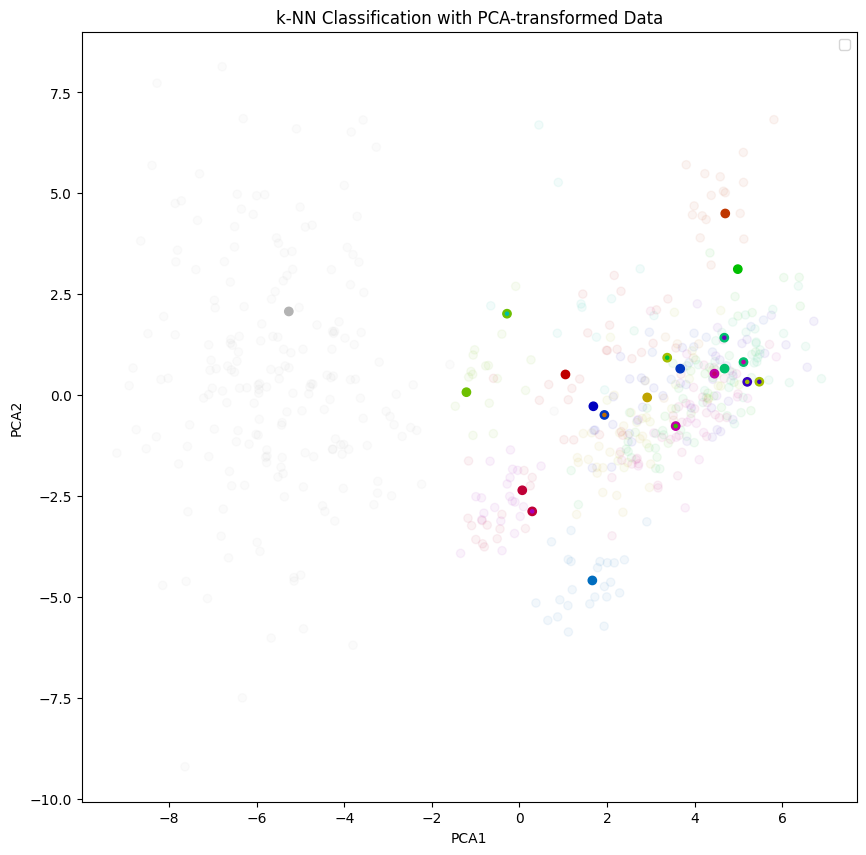

In [139]:
training_batches = np.array([transform_to_pc(training_dataset[batch], components[:10]) for batch in training_dataset])
training_labels = np.array([batch.split('_')[1] for batch in training_dataset])
testing_batches = np.array([transform_to_pc(holdout_dataset[batch], components[:10]) for batch in holdout_dataset])
testing_labels = np.array([batch.split('_')[1] for batch in holdout_dataset])

predictions = k_nearest_neighbours(training_batches, training_labels, testing_batches, 5)
print(predictions)
print(str((predictions == testing_labels).sum()) + ' out of ' + str(len(testing_labels)))

# Visualization example:
plt.figure(figsize=(10, 10))
plt.scatter([batch[0] for batch in training_batches], [batch[1] for batch in training_batches], c=[colour_list[batch.split('_')[1]] for batch in training_dataset], alpha=0.05)
plt.scatter([batch[0] for batch in testing_batches], [batch[1] for batch in testing_batches], c=[colour_list[batch] for batch in predictions])
plt.scatter([batch[0] for batch in testing_batches], [batch[1] for batch in testing_batches], c=[colour_list[batch] for batch in testing_labels], s = 5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.title('k-NN Classification with PCA-transformed Data')
plt.show()

In [153]:
def test_suite() :
    results = {}  # Dictionary to store accuracy results for each (d, k) pair

    # turn all data processing into functions
    
    # for d in range(len(components)) :
    for d in range(1, 6) :
        training_batches = np.array([transform_to_pc(training_dataset[batch], components[:d]) for batch in training_dataset])
        training_labels = np.array([batch.split('_')[1] for batch in training_dataset])
        testing_batches = np.array([transform_to_pc(holdout_dataset[batch], components[:d]) for batch in holdout_dataset])
        testing_labels = np.array([batch.split('_')[1] for batch in holdout_dataset])
        
        for k in range(1, 25) :
            predictions = k_nearest_neighbours(training_batches, training_labels, testing_batches, k)
            
            # Calculate accuracy
            correct = np.sum(predictions == testing_labels)
            accuracy = correct / len(testing_labels)  # Proportion of correct predictions
            
            # Store results
            results[(d, k)] = accuracy

    # Some way of displaying accuracy over various d and k
    plt.figure(figsize=(10, 6))
    for k in range(1, 25):
        accuracies = [results[(d, k)] for d in range(1, 6)]
        plt.plot(range(1, 6), accuracies, label=f'k={k}')
    
    plt.xlabel('Number of Principal Components (d)')
    plt.ylabel('Accuracy')
    plt.title('k-NN Accuracy vs Number of Principal Components')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results

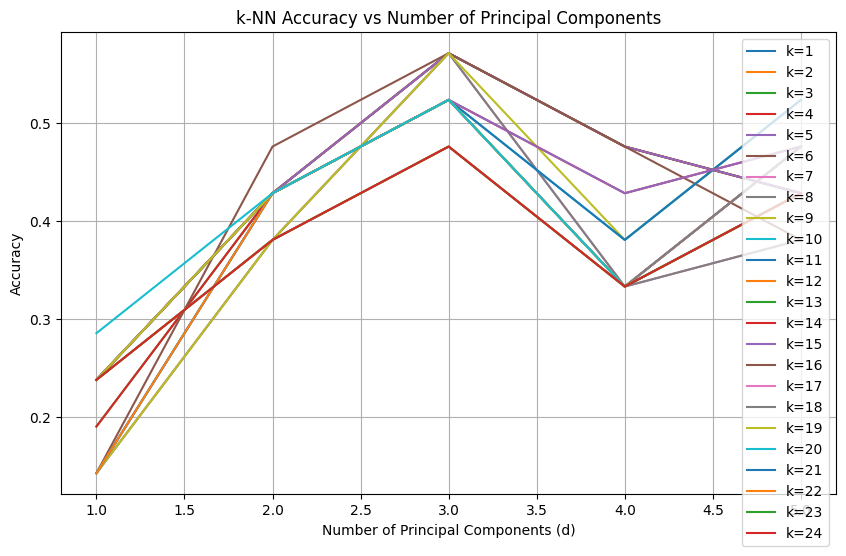

In [155]:
_ = test_suite()